In [1]:
# Find current working directory
import os 
cwd = os.getcwd()
print(cwd)

C:\Users\Michael\Amazon Drive\CarND-Advanced-Lane-Lines


In [2]:
# Calibrate the camera 

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import glob

# prepare object points
nx = 9 # enter the number of inside corners in x
ny = 6 # enter the number of inside corners in y
print(nx)
# Make a list of calibration images
# Find current working directory (CWD)
cwd = os.getcwd()
# Import calibration images in BGR format from 'camera_cal' folder in CWD 
fnames = cwd+'\camera_cal\calibration*.jpg'

images = glob.glob(fnames)

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x, y coordinates



9


In [3]:
for image in images: 
    
    img = cv2.imread(image)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #print(ret)

# If found, draw corners
    if ret == True:
    # Draw and display the corners
        imgpoints.append(corners)
        #print(corners)
        objpoints.append(objp)
    
    # Draw detected corners 
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    
        

In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)



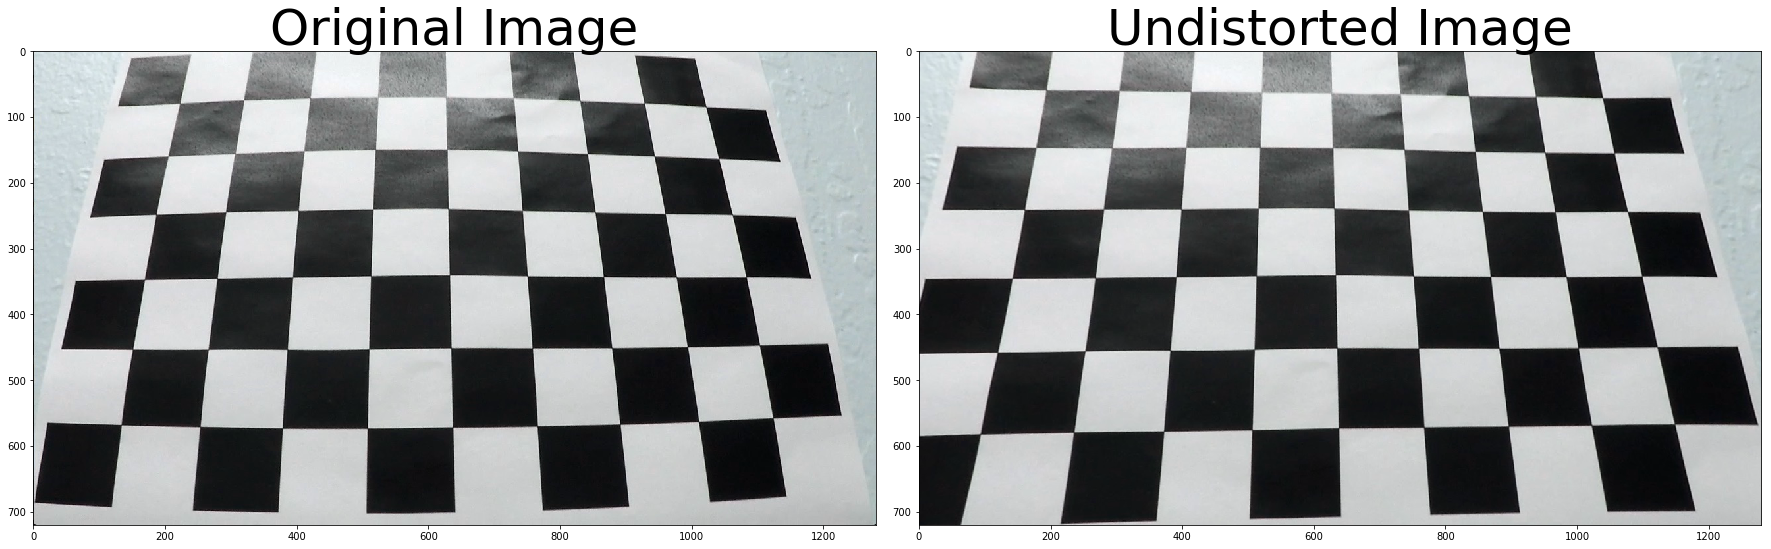

In [5]:
test_image_path = cwd+'\camera_cal\calibration3.jpg'
img = cv2.imread(test_image_path)

undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


# Find Undistorted Warped Image

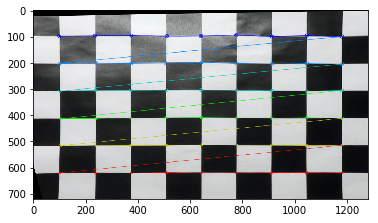

In [6]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients

def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)



plt.imshow(top_down)
plt.show()


In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import glob



class MyVideoProcessor(object):

    def __init__(self, Mysmooth_factor = 10):
        
        self.recent_left_fits = []
        self.recent_right_fits = []
        
        self.recent_left_fits_m = []
        self.recent_right_fits_m = []
        
        self.last_fit_left = []
        self.last_fit_right = []
        
        self.last_fit_left_m = []
        self.last_fit_right_m = []
        
        self.last_left_fitx = []
        self.last_right_fitx = []
        
        self.last_fit_left_par = []
        self.last_fit_right_par = []
        
        self.last_fitx_left_par = [] 
        self.last_fitx_right_par = []
        
        self.last_slope_diff = []
        
        self.last_fit_left_width = []
        self.last_fit_right_width = []
        self.recent_last_fit_left_width = []
        self.recent_last_fit_right_width = []  
        
        self.last_fit_left_width_m = []
        self.last_fit_right_width_m = []
        self.recent_last_fit_left_width_m = []
        self.recent_last_fit_right_width_m = []  
        
        
        self.smooth_factor = Mysmooth_factor
        

    def process_image(self, img):
        
        previous_left_fitx = self.last_left_fitx
        previous_right_fitx = self.last_right_fitx
        
        
        previous_left_fit = self.last_fit_left
        previous_right_fit = self.last_fit_right
        
        previous_left_fit_par = self.last_fit_left_par
        previous_right_fit_par = self.last_fit_right_par
        
        previous_left_fitx_par = self.last_fitx_left_par
        previous_right_fitx_par = self.last_fitx_right_par
        
        previous_slope_diff = self.last_slope_diff
        
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        img = undist
        
        imshape = img.shape
        bottom = imshape[0]
        right_side = imshape[1]


        # Define four sided polygon 
        

        top_left_src = [588, 454]

        top_right_src = [695, 454]

        bottom_right_src = [1135,bottom]

        bottom_left_src = [185,bottom]  

        vertices = np.array([[bottom_left_src, top_left_src, top_right_src, bottom_right_src]], dtype=np.int32)

        ##
        top_left_dst = [320, 1]

        top_right_dst = [920, 1]

        bottom_right_dst = [920, 720]

        bottom_left_dst = [320,720]  

        def warp(img): 

            img_size = (img.shape[1], img.shape[0])

            offset = 100

            src = np.float32([[top_left_src ,top_right_src ,bottom_right_src ,bottom_left_src ]])

            dst = np.float32([top_left_dst, top_right_dst, bottom_right_dst, bottom_left_dst])

            M = cv2.getPerspectiveTransform(src, dst)
            Minv = cv2.getPerspectiveTransform(dst, src)

            warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

            return warped, Minv, M 

        warped_image, Minv, Matrix = warp(img)


        vertices = np.array([[bottom_left_src,top_left_src, top_right_src, bottom_right_src]], dtype=np.int32) 
       
        
        def binary(warped_image):
            ##
            # Create warped binary image 

            # Convert to HLS color space and separate the S channel
            # Note: img is the undistorted image
            hls = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HLS)
            s_channel = hls[:,:,2]
#             l_channel = hls[:,:,1]

            hsv = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HSV)
            v_channel_hsv = hsv[:,:,2]
#             s_channel_hsv = hsv[:,:,1]
#             h_channel_hsv = hsv[:,:,0]



            # Grayscale image
            # NOTE: we already saw that standard grayscaling lost color information for the lane lines
            # Explore gradients in other colors spaces / color channels to see what might work better
            gray = cv2.cvtColor(warped_image, cv2.COLOR_RGB2GRAY)

            # Sobel x
            sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize = 15) # Take the derivative in x
            abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
            scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

            # Threshold x gradient
            thresh_min = 20
            thresh_max = 100
            sxbinary = np.zeros_like(scaled_sobel)
            sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

            # Threshold color channel
            s_thresh_min = 190
            s_thresh_max = 255
            s_binary = np.zeros_like(s_channel)
            s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

            # Threshold l color channel 
#             l_thresh_min = 200
#             l_thresh_max = 255
#             l_binary = np.zeros_like(l_channel)
#             l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

            # Threshold v color channel 
            v_thresh_min = 230
            v_thresh_max = 255
            v_binary = np.zeros_like(v_channel_hsv)
            v_binary[(v_channel_hsv >= v_thresh_min) & (v_channel_hsv <= v_thresh_max)] = 1

            # Stack each channel to view their individual contributions in green and blue respectively
            # This returns a stack of the two binary images, whose components you can see as different colors
            color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

            # Combine the three binary thresholds 
            bin_warped = np.zeros_like(sxbinary)
            bin_warped[(s_binary == 1) | (sxbinary ==1) | (v_binary ==1)] = 1
            
        
            return bin_warped
    
        binary_warped = binary(warped_image)
        
        

        
        def region_of_interest(img, vertices):
            """
            Applies an image mask.

            Only keeps the region of the image defined by the polygon
            formed from `vertices`. The rest of the image is set to black.
            """
            #defining a blank mask to start with
            mask = np.zeros_like(img)   

            #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
            if len(img.shape) > 2:
                channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
                ignore_mask_color = (255,) * channel_count
            else:
                ignore_mask_color = 255

            #filling pixels inside the polygon defined by "vertices" with the fill color    
            cv2.fillPoly(mask, vertices, ignore_mask_color)

            #returning the image only where mask pixels are nonzero
            masked_image = cv2.bitwise_and(img, mask)
            return masked_image

        top_left_msk = [200, 0]

        top_right_msk = [1190, 0]

        bottom_right_msk = [1190,bottom]

        bottom_left_msk = [140,bottom]  


        mask_vertices = np.array([[bottom_left_msk, top_left_msk, top_right_msk, bottom_right_msk]], dtype=np.int32)      

        binary_warped = region_of_interest(binary_warped, mask_vertices)

        ##
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # If this is the first image in the video or if the difference in slope 
        # between the two lane markers in the previous frame is greater than some value
        # start a new search for lane markers. 
        if len(previous_left_fit) == 0 or max(previous_slope_diff) >=0.15: 
            
                
            # Choose the number of sliding windows
            nwindows = 9
            # Set height of windows
            window_height = np.int(binary_warped.shape[0]/nwindows)
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base
            # Set the width of the windows +/- margin
            margin = 100
            # Set minimum number of pixels found to recenter window
            minpix = 50
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                (0,255,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                (0,255,0), 2) 
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds] 

            # Fit a second order polynomial to each.
            # np.polyfit returns the polynomial coefficients A, B and C (Ay^2 + By + C).
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            
            # Left and right lane polynomial coefficients in m space
            left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
            right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
            
            # Store the coefficients to be used 
            self.last_fit_left = left_fit 
            self.last_fit_right = right_fit 
            
            self.last_fit_left_m = left_fit_m 
            self.last_fit_right_m = right_fit_m 
            
            
            # Save the most recent coefficients. 
            # The number of coefficients stored from the 
            # previous frames is dependent on smooth_factor
            self.recent_left_fits.append(left_fit)
            self.recent_right_fits.append(right_fit)
            
            self.recent_left_fits_m.append(left_fit_m)
            self.recent_right_fits_m.append(right_fit_m)
            
            # If there are sufficient coefficients from the previous frames, 
            # use the average of these coefficients to smooth the lane detection output. 
            if len(self.recent_left_fits) >= self.smooth_factor:
                
                left_fit = np.average(self.recent_left_fits[-self.smooth_factor:], axis = 0)
                right_fit = np.average(self.recent_right_fits[-self.smooth_factor:], axis = 0)
                
                left_fit_m = np.average(self.recent_left_fits_m[-self.smooth_factor:], axis = 0)
                right_fit_m = np.average(self.recent_right_fits_m[-self.smooth_factor:], axis = 0)
                
                self.recent_left_fits.append(left_fit)
                self.recent_right_fits.append(right_fit)
                
                self.recent_left_fits_m.append(left_fit_m)
                self.recent_right_fits_m.append(right_fit_m)
       
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            
            # Find the slope of the identified lane markers at every point 
            # along the lane markers
            left_slope = 2*left_fit[0]*ploty + left_fit[1]
            right_slope = 2*right_fit[0]*ploty + right_fit[1]
            
            # Find the difference in slopes between the left and right lines. 
            # Lines with similar slopes are approximately parallel. 
            slope_diff = (left_slope) - (right_slope)
            slope_diff = abs(slope_diff)
           
            # Write the second order polynomials for the right and left lane markers. Ax^2 + By + C. 
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            
            
            
        else:
            # Assume you now have a new warped binary image 
            # from the next frame of video (also called "binary_warped")
            # It's now much easier to find line pixels!
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            margin = 50

            # nonzerox is 
            # left_fit[0] is 
            left_lane_inds = ((nonzerox > (previous_left_fit[0]*(nonzeroy**2) + previous_left_fit[1]*nonzeroy + 
            previous_left_fit[2] - margin)) & (nonzerox < (previous_left_fit[0]*(nonzeroy**2) + 
            previous_left_fit[1]*nonzeroy + previous_left_fit[2] + margin))) 

            right_lane_inds = ((nonzerox > (previous_right_fit[0]*(nonzeroy**2) + previous_right_fit[1]*nonzeroy + 
            previous_right_fit[2] - margin)) & (nonzerox < (previous_right_fit[0]*(nonzeroy**2) + 
            previous_right_fit[1]*nonzeroy + previous_right_fit[2] + margin)))  

            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            
            # Fit a second order polynomial to each.
            # np.polyfit returns the polynomial coefficients A, B and C (Ay^2 + By + C).
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            
            # Left and right lane polynomial coefficients in m space
            left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
            right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
            
            self.last_fit_left = left_fit 
            self.last_fit_right = right_fit
            
            self.last_fit_left_m = left_fit_m 
            self.last_fit_right_m = right_fit_m
            
            
            self.recent_left_fits.append(left_fit)
            self.recent_right_fits.append(right_fit)
            
            self.recent_left_fits_m.append(left_fit_m)
            self.recent_right_fits_m.append(right_fit_m)
            
            
            if len(self.recent_left_fits) >= self.smooth_factor:
                
                left_fit = np.average(self.recent_left_fits[-self.smooth_factor:], axis = 0)
                right_fit = np.average(self.recent_right_fits[-self.smooth_factor:], axis = 0)
                
                left_fit_m = np.average(self.recent_left_fits_m[-self.smooth_factor:], axis = 0)
                right_fit_m = np.average(self.recent_right_fits_m[-self.smooth_factor:], axis = 0)
                
                self.recent_left_fits.append(left_fit)
                self.recent_right_fits.append(right_fit)
                
                self.recent_left_fits_m.append(left_fit_m)
                self.recent_right_fits_m.append(right_fit_m)
                
            #Left and right lines when lines were paralell 
            self.last_fit_left_par = left_fit 
            self.last_fit_right_par = right_fit
            
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
            
            # Write the second order polynomials for the right and left lane markers. Ay^2 + By + C. 
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            #print('fast')
            
            #Left and right lines when lines were approximately paralell 
            self.last_fitx_left_par = left_fitx 
            self.last_fitx_right_par = right_fitx
            
        self.last_left_fitx = left_fitx 
        self.last_right_fitx = right_fitx  
        
        # Find the slope of the identified lane markers at every point 
        # along the lane markers
        left_slope = 2*left_fit[0]*ploty + left_fit[1]
        right_slope = 2*right_fit[0]*ploty + right_fit[1] 
        
        # Find the difference in slopes between the left and right lines. 
        # Lines with similar slopes are approximately parallel. 
        slope_diff = (left_slope) - (right_slope)
        slope_diff = abs(slope_diff)
        
        self.last_slope_diff = slope_diff
        
        
        

        
        if max(slope_diff) < 0.4:
            self.last_fit_left_width = left_fit 
            self.last_fit_right_width = right_fit
            self.recent_last_fit_left_width.append(left_fit)
            self.recent_last_fit_right_width.append(right_fit)
            
            self.last_fit_left_width_m = left_fit_m 
            self.last_fit_right_width_m = right_fit_m
            self.recent_last_fit_left_width_m.append(left_fit_m)
            self.recent_last_fit_right_width_m.append(right_fit_m)
            

            
        # If the max slope is greater than () use the polynomial coefficients from the last few frames   
        if max(slope_diff) >= 0.4:
            print('Max slope diff is', max(slope_diff))
            
            left_fit = np.average(self.recent_last_fit_left_width[-self.smooth_factor:], axis = 0)
            right_fit = np.average(self.recent_last_fit_right_width[-self.smooth_factor:], axis = 0)
            
            left_fit_m = np.average(self.recent_last_fit_left_width_m[-self.smooth_factor:], axis = 0)
            right_fit_m = np.average(self.recent_last_fit_right_width_m[-self.smooth_factor:], axis = 0)
            
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            
            print('Revert to last frame')



        ##
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)
#         left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
#         right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        
        left_curverad = ((1 + (2*left_fit_m[0]*y_eval*ym_per_pix + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
        right_curverad = ((1 + (2*right_fit_m[0]*y_eval*ym_per_pix + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])

        avg_curverad = np.mean(np.array([left_curverad, right_curverad]))
        avg_curverad = round(avg_curverad,2)

        
        # Find the vehicle's offset from the centre of the road. 
        camera_pos = img.shape[1]/2
        lane_center = (left_fitx[719] + right_fitx[719])/2

        center_offset_pixels = abs(camera_pos - lane_center)
        center_offset_m = center_offset_pixels*xm_per_pix
        center_offset_m = round(center_offset_m,2)

        ##

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))


        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))


        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

        cv2.putText(result, 'Curve rad is {0} m'.format(avg_curverad), (10, 100), cv2.FONT_HERSHEY_PLAIN, 6, 200, 8)
        cv2.putText(result, 'Offset is {0} m'.format(center_offset_m), (10, 200), cv2.FONT_HERSHEY_PLAIN, 6, 200, 8)



        return result

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:

my_video_processor_object = MyVideoProcessor()

white_output = 'test_videos_output/project_video_part_15Mar18_1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,25)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(my_video_processor_object.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_part_15Mar18_1.mp4
[MoviePy] Writing video test_videos_output/project_video_part_15Mar18_1.mp4


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [02:18<00:32,  6.99it/s]

Max slope diff is 0.411019838614
Revert to last frame


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [02:18<00:32,  6.94it/s]

Max slope diff is 0.564876787254
Revert to last frame


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [02:18<00:32,  6.80it/s]

Max slope diff is 0.870237399085
Revert to last frame


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [02:19<00:33,  6.57it/s]

Max slope diff is 0.743133700692
Revert to last frame


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [02:19<00:36,  6.08it/s]

Max slope diff is 0.868426988155
Revert to last frame


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [02:19<00:38,  5.72it/s]

Max slope diff is 1.0785468747
Revert to last frame


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [02:19<00:40,  5.42it/s]

Max slope diff is 0.972176180946
Revert to last frame


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [02:19<00:41,  5.30it/s]

Max slope diff is 1.36948207928
Revert to last frame


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [02:20<00:41,  5.18it/s]

Max slope diff is 2.13386043668
Revert to last frame


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [02:20<00:42,  5.04it/s]

Max slope diff is 2.1729989008
Revert to last frame


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [02:20<00:44,  4.88it/s]

Max slope diff is 1.97664045112
Revert to last frame


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [02:20<00:41,  5.10it/s]

Max slope diff is 2.05275313555
Revert to last frame


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [02:20<00:40,  5.32it/s]

Max slope diff is 1.47337219482
Revert to last frame


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [02:21<00:38,  5.51it/s]

Max slope diff is 0.869070037106
Revert to last frame


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [02:21<00:37,  5.67it/s]

Max slope diff is 0.720570965917
Revert to last frame


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [02:21<00:36,  5.81it/s]

Max slope diff is 0.589655462163
Revert to last frame


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [02:21<00:34,  5.98it/s]

Max slope diff is 0.458748661595
Revert to last frame


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:50<00:00,  7.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_part_15Mar18_1.mp4 

Wall time: 2min 51s
